# Import

In [1]:
import numpy as np
import pandas as pd
import json
import gc
import re
import os
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import torch
# -------------------------------------------------------------------
# Local file path (Windows)
# Make sure this matches the folder where you extracted the dataset
# -------------------------------------------------------------------
DATA_PATH = r"C:\Users\Geeks2_PC41\Projec_sim\Intelligent Bank"

# Load CSV files
transaction_df = pd.read_csv(os.path.join(DATA_PATH, "transactions_data_south_africa.csv"))
card_df = pd.read_csv(os.path.join(DATA_PATH, "cards_data_south_africa.csv"))
users_df = pd.read_csv(os.path.join(DATA_PATH, "user_data_south_africa.csv"))

# Load MCC JSON file
mcc_series = pd.read_json(os.path.join(DATA_PATH, "mcc_codes.json"), typ='series')
mcc_df = mcc_series.reset_index()
mcc_df.columns = ['mcc_code', 'description']

# Load labels JSON
file_path = os.path.join(DATA_PATH, 'train_fraud_labels.json')

with open(file_path, 'r') as f:
    raw_json_data = json.load(f)

transaction_labels_dict = raw_json_data['target']

train_fraud_labels = pd.Series(transaction_labels_dict).reset_index()
train_fraud_labels.columns = ['transaction_id', 'is_fraud']
train_fraud_labels['transaction_id'] = pd.to_numeric(train_fraud_labels['transaction_id'])

print("\nAll data files loaded successfully on local computer.")


All data files loaded successfully on local computer.


In [2]:
data_dict = {'transaction': transaction_df,
             'card': card_df,
             'user': users_df,
             'mcc': mcc_df,
             'fraud_labels': train_fraud_labels
            } 
print("\nSuccessfuly save all dataframe in a dictionary called data_dict")


Successfuly save all dataframe in a dictionary called data_dict


# Cleaning

In [3]:
# ====================
# Basic prprosessing
# ====================

def cleaned_transaction(df):
    df = df.copy()

    df['date'] = pd.to_datetime(df['date']) # conviert to datetime
    df['errors'] = df['errors'].fillna('no error') # fill nulls
    df['merchant_state'] = np.where(df['merchant_city'] == 'ONLINE', 'ONLINE', df['merchant_state']) # check if city is online and fill state
    df['zip'] = df['zip'] = np.where(df['merchant_city'] == 'ONLINE', 0, df['zip']) # fill zip if city == 'Online' or keep original if false
    df['mcc'] = df['mcc'].fillna(5812) # fill nulls
    return df

# conviert to datetime
data_dict['card']['expires'] = pd.to_datetime(data_dict['card']['expires']) 
data_dict['card']['acct_open_date'] = pd.to_datetime(data_dict['card']['acct_open_date'])
data_dict['transaction']["date"] = pd.to_datetime(data_dict['transaction']["date"])

print("\nSuccessfuly preprocessed")


Successfuly preprocessed


Save cleaned data


In [4]:
mcc_cl = data_dict['mcc']
transaction_cl = cleaned_transaction(data_dict['transaction'])
card_cl = data_dict['card'].drop(columns=data_dict['card'][['card_on_dark_web']])
user_cl = data_dict['user']
fraud_labels_cl = data_dict['fraud_labels']
print("\nSuccessfuly saved")


Successfuly saved


# Merge


In [5]:
def column_name_standardization(transaction, card, mcc, user):
    transaction = transaction.rename(columns={'id':'transaction_id'})
    card = card.rename(columns={'id': 'card_id'})
    mcc = mcc.rename(columns={'mcc_code': 'mcc'})
    user = user.rename(columns={'id': 'client_id'})
    return transaction, card, mcc, user
transaction_cl, card_cl, mcc_cl, user_cl = column_name_standardization(transaction_cl, card_cl, mcc_cl, user_cl)

In [6]:
df_merge = transaction_cl.copy()
df_merge = df_merge.merge(card_cl, how='left', on=['card_id','client_id'])
df_merge = df_merge.merge(mcc_cl, how='left', on=['mcc'])
df_merge = df_merge.merge(user_cl, how='left', on=['client_id'])
df_merge = df_merge.merge(fraud_labels_cl, how='left', on=['transaction_id'])

In [7]:
df = df_merge.copy()

# Feature engineering

In [8]:
# Is_fraud to binary
df['target'] = df['is_fraud'].map({'Yes': 1, 'No': 0})


FULL FRAUD FEATURE ENGINEERING PIPELINE (PRODUCTION SAFE)


In [9]:
# -----------------------------------------------------
# TIME FEATURES
# -----------------------------------------------------
def time_features(df):
    df = df.copy()
    # Sort
    df = df.sort_values(["client_id", "date"]).reset_index(drop=True)

    df["hour"] = df["date"].dt.hour.astype("int32")
    df["dayofweek"] = df["date"].dt.dayofweek.astype("int32")
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype("int32")
    df["is_night"] = df["hour"].between(0, 5).astype("int32")
    df["is_month_end"] = df["date"].dt.is_month_end.astype("int32")
    return df
fe = time_features(df)

In [10]:
def transaction_features(df):
    df = df.copy()
    # Sort
    df = df.sort_values(["client_id", "date"]).reset_index(drop=True)

    # Set date as index temporarily
    df_temp = df.set_index("date")

    # Transactions last 24h
    rolling_24h = (
        df_temp.groupby("client_id")["amount"]
               .rolling("1D", closed="left")
               .count()
    )
    df["txn_last_24h"] = (
        rolling_24h.reset_index(level=0, drop=True)
                   .astype("float32")
                   .fillna(0)
                   .values
    )

    # Spend last 24h (use float64 for money precision)
    spend_24h = (
        df_temp.groupby("client_id")["amount"]
               .rolling("1D", closed="left")
               .sum()
    )

    # --- Diff features ---
    df["hours_since_last_txn"] = (
        df.groupby("client_id")["date"]
          .diff()
          .dt.total_seconds()
          .div(3600)
          .astype("float32")
          .fillna(0)
    )

    return df

fe = transaction_features(fe)

In [11]:
def behavioral_features(df):
    df = df.copy()

    # Ensure chronological order per client
    df = df.sort_values(["client_id", "date"]).reset_index(drop=True)

    # --- Expanding behavior features ---
    def expanding_mean_shift(x):
        return x.expanding().mean().shift()

    def expanding_std_shift(x):
        return x.expanding().std(ddof=0).shift()

    # Card-level behavior
    df["card_avg_amount"] = (
        df.groupby("card_id")["amount"]
          .transform(expanding_mean_shift)
          .astype("float32")
          .fillna(0)
    )
    df["card_std_amount"] = (
        df.groupby("card_id")["amount"]
          .transform(expanding_std_shift)
          .astype("float32")
          .fillna(0)
    )

    # Client-level behavior
    df["client_avg_amount"] = (
        df.groupby("client_id")["amount"]
          .transform(expanding_mean_shift)
          .astype("float32")
          .fillna(0)
    )

    # Z-score deviation
    df["amount_zscore_card"] = (
        (df["amount"] - df["card_avg_amount"]) /
        (df["card_std_amount"] + 1e-6)
    ).astype("float32").fillna(0)

    # Log amount features
    df["abs_amount"] = df["amount"].abs().astype("float32").fillna(0)
    df["log_amount"] = np.log1p(df["abs_amount"]).astype("float32").fillna(0)
    df["amount_sign"] = np.sign(df["amount"]).astype("int8").fillna(0)


    # --- Merchant behavior ---
    df["merchant_txn_count"] = df.groupby(["card_id", "merchant_id"]).cumcount().fillna(0)
    df["new_merchant"] = (df["merchant_txn_count"] == 0).astype("int8").fillna(0)

    df["rapid_repeat_merchant"] = (
        (df["merchant_id"] == df.groupby("card_id")["merchant_id"].shift(1)) &
        ((df["date"] - df.groupby("card_id")["date"].shift(1))
         .dt.total_seconds() < 300)
    ).astype("int8").fillna(0)


    # --- Time behavior deviation ---
    df["hour"] = df["date"].dt.hour.fillna(0)
    # --- Account stability ---
    df["account_age_years"] = ((df["date"] - df["acct_open_date"]).dt.days.div(365).astype("float32").fillna(0))
    if "yearly_income" in df.columns:
        df["spend_to_income_ratio"] = (df["amount"] / (df["yearly_income"] + 1e-6)).astype("float32").fillna(0)

    # --- Transaction sequence ---
    df["first_occurrence"] = (~df["card_id"].duplicated()).astype(int)

    return df
fe = behavioral_features(fe)

In [12]:
def age_features(df):
    # Standard demographic groups
    demographic_bins = {
        'Gen Z': (0, 25),
        'Millennials': (26, 40),
        'Gen X': (41, 56),
        'Boomers': (57, 75),
        'Silent': (76, 200)
    }

    # Create a function to map ages
    def get_generation(age):
        for gen, (low, high) in demographic_bins.items():
            if low <= age <= high:
                return gen
        return 'Unknown'

    df['generation'] = df['retirement_age'].apply(get_generation)
    return df
fe = age_features(fe)

# Modelling

In [13]:
# ===============================
# 1. Imports
# ===============================
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, auc

from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# =====================
# 2. Data prep
# =====================

selected_features = [
    "amount_zscore_card",
    "abs_amount",
    "amount",
    'client_avg_amount',
    "description",
    "spend_to_income_ratio",
    "new_merchant",
    "zip",
    "mcc",
    "use_chip",
    "errors",
    "merchant_id",
    'merchant_state',
    'merchant_city',
    'card_brand',
    'card_type',
    'has_chip',
    'current_age',
    "generation",
    "first_occurrence",
    'is_weekend',
    "target",
    "txn_last_24h",
    "amount_sign",
    "account_age_years",
]

'''df_ft = [
    "amount",
    "description",
    "zip",
    "mcc",
    "use_chip",
    "errors",
    'merchant_state',
    'merchant_city',
    'card_brand',
    'card_type',
    'has_chip',
    'current_age'
]'''

print("features selected!")

features selected!


In [15]:
df = fe.copy()

In [16]:
df.shape

(12858754, 57)

In [17]:
df_model = df[selected_features]
df_model = df_model[df_model['target'].notnull()]
df_target_null = df_model[df_model['target'].isnull()]

In [18]:
df_model.shape

(8615533, 25)

In [19]:
# Fraud percentage calculation
fraud_count = df["target"].sum()
total_count = len(df)
fraud_percentage = (fraud_count / total_count) * 100

print(f"Fraud cases: {fraud_count}")
print(f"Total transactions: {total_count}")
print(f"Fraud percentage: {fraud_percentage:.2f}%")

Fraud cases: 12816.0
Total transactions: 12858754
Fraud percentage: 0.10%


In [20]:
X = df_model.drop(columns=['target'])
y = df_model['target']
print(X.shape, y.shape)

(8615533, 24) (8615533,)


In [21]:
X = pd.get_dummies(X, columns=['use_chip', 'card_brand', 'card_type', 'has_chip', 'generation'], drop_first=True)

from sklearn.preprocessing import LabelEncoder

for col in ['merchant_city','merchant_state','errors','description']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

In [22]:
# ===============================
# 3. Train / Test Split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y,random_state=45)


In [23]:
# ===============================
# 4. Train XGBoost
# ===============================

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    random_state=42
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [24]:
# ===============================
# 5. Predict Probabilities
# ===============================
y_pred = xgb_model.predict_proba(X_test)[:, 1]

In [42]:
# ===============================
# 6. Threshold
# ===============================
THRESHOLD = 0.1
y_proba = (y_pred >= THRESHOLD).astype(int)

In [43]:
print("\nClassification Report:")
print(classification_report(y_test, y_proba, target_names=["Non Fraud", "Fraud"]))


Classification Report:
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00   2150680
       Fraud       0.68      0.73      0.70      3204

    accuracy                           1.00   2153884
   macro avg       0.84      0.86      0.85   2153884
weighted avg       1.00      1.00      1.00   2153884



In [44]:
# Precision-recall curve (use probabilities)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# PR-AUC
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# ROC AUC (use probabilities)
print("ROC AUC:", roc_auc_score(y_test, y_pred))

PR-AUC: 0.771023322361653
ROC AUC: 0.9892147379824728


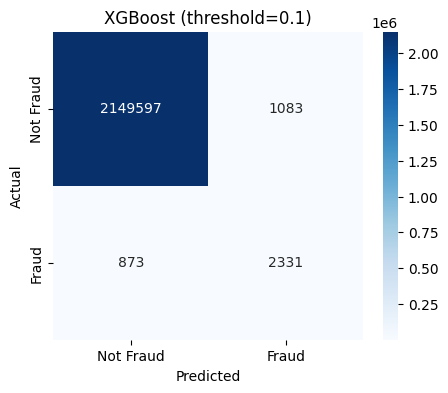

In [45]:
# Confusion matrix (use thresholded predictions)
cm = confusion_matrix(y_test, y_proba)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f'XGBoost (threshold={THRESHOLD})')
plt.show()

In [29]:
'''# Confusion matrix values from your model
true_negatives = cm[0,0]
false_positives = cm[0,1]
false_negatives = cm[1,0]
true_positives = cm[1,1]

# Business assumptions
avg_fraud_value = 500      # average loss per fraud case / R500 
avg_customer_inconvenience = 50  # cost per false positive / R50 

# Business impact calculations
fraud_prevented = true_positives * avg_fraud_value
fraud_missed = false_negatives * avg_fraud_value
customer_inconvenience_cost = false_positives * avg_customer_inconvenience

net_savings = fraud_prevented - fraud_missed - customer_inconvenience_cost
total_loss = fraud_prevented - net_savings

# Print results
print(f"Fraud prevented: R {fraud_prevented:,}")
print(f"Fraud missed: R {fraud_missed:,}")
print(f"Customer inconvenience cost: R {customer_inconvenience_cost:,}")
print(f"Total loss: R {total_loss:,}")
print(f"Net business impact: R {net_savings:,}")'''

'# Confusion matrix values from your model\ntrue_negatives = cm[0,0]\nfalse_positives = cm[0,1]\nfalse_negatives = cm[1,0]\ntrue_positives = cm[1,1]\n\n# Business assumptions\navg_fraud_value = 500      # average loss per fraud case / R500 \navg_customer_inconvenience = 50  # cost per false positive / R50 \n\n# Business impact calculations\nfraud_prevented = true_positives * avg_fraud_value\nfraud_missed = false_negatives * avg_fraud_value\ncustomer_inconvenience_cost = false_positives * avg_customer_inconvenience\n\nnet_savings = fraud_prevented - fraud_missed - customer_inconvenience_cost\ntotal_loss = fraud_prevented - net_savings\n\n# Print results\nprint(f"Fraud prevented: R {fraud_prevented:,}")\nprint(f"Fraud missed: R {fraud_missed:,}")\nprint(f"Customer inconvenience cost: R {customer_inconvenience_cost:,}")\nprint(f"Total loss: R {total_loss:,}")\nprint(f"Net business impact: R {net_savings:,}")'

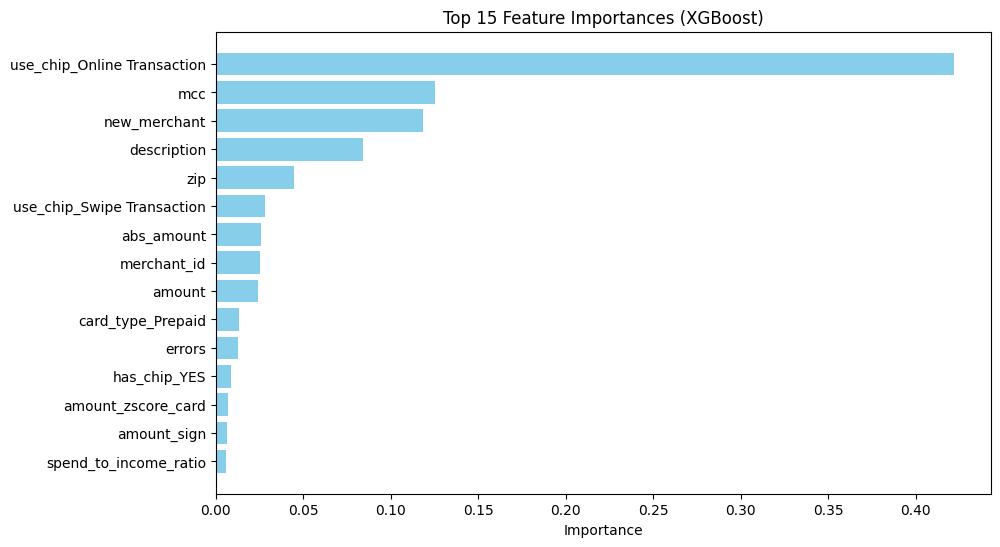

In [30]:
# feature importance
feature_importance = (
    pd.DataFrame({
        'feature': X.columns,
        'importance': xgb_model.feature_importances_
    })
    .sort_values('importance', ascending=False)
)

# Plot top 21 features
top_features = feature_importance.head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

In [31]:
print("\nAll Features (Importantance-DSC):")
display(feature_importance)


All Features (Importantance-DSC):


,feature,importance
19,use_chip_Online Transaction,0.421969
8,mcc,0.125123
6,new_merchant,0.118690
4,description,0.083891
7,zip,0.044509
20,use_chip_Swipe Transaction,0.028093
1,abs_amount,0.025564
10,merchant_id,0.025391
2,amount,0.024208
25,card_type_Prepaid,0.013382


In [40]:
feat_imp = ['new_merchant','use_chip_Online Transaction',
            'description', 'mcc', 'merchant_id',
            'use_chip_Swipe Transaction','card_type_Prepaid',
            'abs_amount','amount',	'has_chip_YES',	'errors']

X = X[feat_imp]

X.shape

(8615533, 11)

In [41]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from xgboost import XGBClassifier
import numpy as np

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(
    xgb_model,
    X_train,
    y_train,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1
)

print("CV PR-AUC:", np.mean(scores))

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1789, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ~~~~~~~~~~~~~~~~~~~~~~~~~^
        missing=self.missing,
        ^^^^^^^^^^^^^^^^^^^^^
    ...<14 lines>...
        feature_types=feature_types,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 702, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
        data=X,
    ...<9 lines>...
        ref=None,
    )
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1264, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 999, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
                                           ~~~~~~~~~~~~~~~~~~~~~^
        data=data,
        ^^^^^^^^^^
    ...<5 lines>...
        data_split_mode=data_split_mode,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\data.py", line 1463, in dispatch_data_backend
    array = np.asarray(data)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\generic.py", line 2036, in __array__
    values = self._values
             ^^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\frame.py", line 1114, in _values
    return ensure_wrapped_if_datetimelike(self.values)
                                          ^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\frame.py", line 16673, in values
    return self._mgr.as_array()
           ~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\managers.py", line 1847, in as_array
    arr = self._interleave(dtype=dtype, na_value=na_value)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\managers.py", line 1880, in _interleave
    result = np.empty(self.shape, dtype=dtype)
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 1.12 GiB for an array with shape (29, 5169319) and data type object

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1789, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ~~~~~~~~~~~~~~~~~~~~~~~~~^
        missing=self.missing,
        ^^^^^^^^^^^^^^^^^^^^^
    ...<14 lines>...
        feature_types=feature_types,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 702, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
        data=X,
    ...<9 lines>...
        ref=None,
    )
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1264, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 999, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
                                           ~~~~~~~~~~~~~~~~~~~~~^
        data=data,
        ^^^^^^^^^^
    ...<5 lines>...
        data_split_mode=data_split_mode,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\data.py", line 1464, in dispatch_data_backend
    return _from_numpy_array(
        data=array,
    ...<3 lines>...
        feature_types=feature_types,
    )
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\data.py", line 287, in _from_numpy_array
    _check_call(
    ~~~~~~~~~~~^
        _LIB.XGDMatrixCreateFromDense(
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<7 lines>...
        )
        ^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 323, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: bad allocation

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1756, in fit
    classes = np.unique(np.asarray(y))
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_arraysetops_impl.py", line 294, in unique
    ret = _unique1d(ar, return_index, return_inverse, return_counts,
                    equal_nan=equal_nan, inverse_shape=ar.shape, axis=None,
                    sorted=sorted)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_arraysetops_impl.py", line 356, in _unique1d
    ar = np.asanyarray(ar).flatten()
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 39.4 MiB for an array with shape (5169319,) and data type float64

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 833, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1789, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ~~~~~~~~~~~~~~~~~~~~~~~~~^
        missing=self.missing,
        ^^^^^^^^^^^^^^^^^^^^^
    ...<14 lines>...
        feature_types=feature_types,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 702, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
        data=X,
    ...<9 lines>...
        ref=None,
    )
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\sklearn.py", line 1264, in _create_dmatrix
    return DMatrix(**kwargs, nthread=self.n_jobs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py", line 999, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
                                           ~~~~~~~~~~~~~~~~~~~~~^
        data=data,
        ^^^^^^^^^^
    ...<5 lines>...
        data_split_mode=data_split_mode,
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\data.py", line 1463, in dispatch_data_backend
    array = np.asarray(data)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\generic.py", line 2036, in __array__
    values = self._values
             ^^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\frame.py", line 1114, in _values
    return ensure_wrapped_if_datetimelike(self.values)
                                          ^^^^^^^^^^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\frame.py", line 16673, in values
    return self._mgr.as_array()
           ~~~~~~~~~~~~~~~~~~^^
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\managers.py", line 1847, in as_array
    arr = self._interleave(dtype=dtype, na_value=na_value)
  File "c:\Users\Geeks2_PC41\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\internals\managers.py", line 1880, in _interleave
    result = np.empty(self.shape, dtype=dtype)
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 1.12 GiB for an array with shape (29, 5169320) and data type object


In [ ]:
xgb_model.fit(X_train, y_train)

'xgb_model.fit(X_train, y_train)'

In [ ]:
from sklearn.metrics import average_precision_score

y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
print("Test PR-AUC:", average_precision_score(y_test, y_pred_proba))

'from sklearn.metrics import average_precision_score\n\ny_pred_proba = xgb_model.predict_proba(X_test)[:, 1]\nprint("Test PR-AUC:", average_precision_score(y_test, y_pred_proba))'

In [ ]:
THRESHOLD = 0.5
y_proba = (y_pred >= THRESHOLD).astype(int)

'THRESHOLD = 0.5\ny_proba = (y_pred >= THRESHOLD).astype(int)'

In [ ]:
print("\nClassification Report:")
print(classification_report(y_test, y_proba, target_names=["Non Fraud", "Fraud"]))

'print("\nClassification Report:")\nprint(classification_report(y_test, y_proba, target_names=["Non Fraud", "Fraud"]))'

In [ ]:
# Precision-recall curve (use probabilities)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# PR-AUC
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# ROC AUC (use probabilities)
print("ROC AUC:", roc_auc_score(y_test, y_pred))

'# Precision-recall curve (use probabilities)\nprecision, recall, thresholds = precision_recall_curve(y_test, y_pred)\n\n# PR-AUC\npr_auc = auc(recall, precision)\nprint("PR-AUC:", pr_auc)\n\n# ROC AUC (use probabilities)\nprint("ROC AUC:", roc_auc_score(y_test, y_pred))'

In [ ]:
# Confusion matrix (use thresholded predictions)
cm = confusion_matrix(y_test, y_proba)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f'XGBoost (threshold={THRESHOLD})')
plt.show()

'# Confusion matrix (use thresholded predictions)\ncm = confusion_matrix(y_test, y_proba)\nplt.figure(figsize=(5,4))\nsns.heatmap(cm, annot=True, fmt=\'d\', cmap=\'Blues\',\n            xticklabels=["Not Fraud", "Fraud"],\n            yticklabels=["Not Fraud", "Fraud"])\nplt.xlabel("Predicted")\nplt.ylabel("Actual")\nplt.title(f\'XGBoost (threshold={THRESHOLD})\')\nplt.show()'